# <center>Livrable Projet DATA SCIENCE</center>

### Contexte

L'entreprise TouNum est une entreprise de numérisation de documents. Elle prospose différents services dont la numérisation de base de document papier pour les entreprises clientes. TouNum veut optimiser et rendre intelligent ce processus de scanning en incluant des outils de Machine Learning. Le gain de temps serait important aux vues des nombreuses données que l'entreprise doit scanner et étiqueter.
Pour cela, TouNum fait appel à CESI pour réaliser cette prestation.

### Objectif

L'objectif est que l'équipe de data scientist de CESI réalise cette solution visant à analyser des photographies pour en déterminer une légende descriptive de manière automatique. Il faudra également améliorer la qualité des images scannées ayant des qualités variables (parfois floues, ou bruitées).

<img src="imageSrc/caption image.PNG"/>

### Enjeux

TouNum devait trier et étiqueter chaque document scanné. La solution délivré par CESI permet l'automatisation de ces tâches en faisant donc gagner un temps non négligeable. Elle va donc pouvoir réaliser plus de contrats et augmenter la satisfaction client.

### Contraintes techniques

L'implémentation des algorithmes doit être réaliser sur Python, notamment les librairies Scikit et TensorFlow. La librairie Pandas doit être utilisé pour manipuler le dataset et ImageIO pour le charger. NumPy et MatPlotLib seront nécessaire pour le calcul scientifique et la modélisation.

Le programme à livrer devra respecter le workflow suivant :

<img src="imageSrc/workflow.PNG"/>

#### Classification:

La classification d'image se fera à l'aide de réseaux de neurones. Cette dernière doit distinguer les photos d'un autre documents, tel que schémas, textes scannés, voir peintures.
TouNoum possède un dataset rempli d'images divers pour entrainer le réseau de neurones.

#### Prétraitement

Le prétraitement dois utiliser des filtres convolutifs afin d'améliorer la qualité. Il doit établir un compromis entre débruitage et affutage.

#### Captionning

Le Captionning devra légender automatiquement les images. Il utilisera deux techniques de Machine Learning : les réseaux de neurones convolutifs (CNN) pour prétraiter l'image en identifiant les zones d’intérêt, et les réseaux de neurones récurrents (RNN) pour générer les étiquettes. Il faudra être vigilant quant aux ressources RAM. Un dataset d'étiquetage classique est disponible pour l’apprentissage supervisé.

### Livrable

La solution doit sous forme de notebook Jupiter entièrement automatisé. Il doit être conçu pour être faciliter mis en production et maintenance.
Il faut démontrer la pertinence du modèle de manière rigoureuse et pédagogique.

#### Jalons

CESI devra dois rendre le prototype complet et fonctionnel du programme pour le 23 janvier. 
TouNum exige également 3 dates de rendu pour suivre la bonne avancé du projet.
<ul>
    <li>18/12/20 : Prétraitement d'image</li>
    <li>15/01/21 : Classification binaire</li>
    <li>20/01/21 : Captioning d'images</li>
    <li>22/01/21 : Démonstration </li>
</ul>


## Livrable 1 - Prétraitement (denoising/sharpening…)

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Il y a deux traitements à réaliser : le débruitage, et l’affutage. Vous devrez produire un notebook Jupyter explicitant ces étapes de prétraitement, et leurs performances. Ces algorithmes s’appuieront sur des notions assez simples autour des filtres de convolution, et les appliqueront pour améliorer la qualité de l’image. Il faudra notamment décider d’un compromis entre dé-bruitage et affutage.

Le notebook devra intégrer :
<ul>
    <li>Le code de chargement du fichier.</li>
    <li>Le code du débruitage sur un sous-ensemble d’images bruitées. Le code doit être accompagné d’explications.</li>
    <li>Le code de l’affutage sur un sous-ensembles d’images floutées. Le code doit être accompagné d’explications.</li>
    <li>
        Une étude de cas explicitant les compromis entre ces deux opérations. Cette partie du livrable doit inclure le bruitage d’images et montrer la perte de détails, ou l’affutage d’images et montrer l’apparition du bruit.
    </li>
</ul>

<b>Ce livrable est à fournir pour le 18/12/2020</b>

## *Importation des librairies utilisées*

In [80]:
import os
import time
import random

# Check if imageio package is installed
try:
    import imageio
except ImportError:
    !pip install imageio
    
import imageio
import matplotlib.pyplot as plt
import numpy as np

# Check if cikit-image package is installed
try:
    import skimage
except ImportError:
    !pip install scikit-image

from skimage import io
from skimage.restoration import estimate_sigma

# Check if opencv-python package is installed
try:
    import cv2
except ImportError:
    !pip install opencv-python

import cv2

import threading
from queue import Queue
from multiprocessing import Pool

import pathlib

# Check if pandas package is installed
try:
    import pandas
except ImportError:
    !pip install pandas

import pandas as pd

import PIL
import PIL.Image

# Check if tensorflow package is installed
try:
    import tensorflow
except ImportError:
    !pip install tensorflow
# Check if tensorflow_datasets package is installed
try:
    import tensorflow_datasets
except ImportError:
    !pip install tensorflow_datasets    


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Check if tensorflow_datasets package is installed
try:
    import keras
except ImportError:
    !pip install keras    
from keras.preprocessing import image

# Livrable 3 
import json
import collections

from PIL import Image

## *Chemins physiques*

In [2]:
blurry_dataset_path = "./Dataset/1/dataset/Blurry/"
noisy_dataset_path = "./Dataset/1/dataset/Noisy/"

deblured_dataset_path = "./Dataset/1/dataset/deblurred/"
denoised_dataset_path = "./Dataset/1/dataset/denoised/"

classification_dataset_path = "./Dataset/2/dataset/"

#### Méthodes utilisées

In [ ]:
# Chargement des images
def get_image(path, filename):
    return io.imread(path + filename)

# Sauvegarde des images
def save_image(path, filename, content):
    #Check if folder exists
    if not os.path.isdir(path):
        os.makedirs(path)
    imageio.imwrite(path + filename , content)

# Retrieve importants informations from data    
def get_metric_stat(pre_data, post_data):
    data = [
        np.array([min(pre_data), max(pre_data), np.median(pre_data), np.average(pre_data)]),
        np.array([min(post_data), max(post_data), np.median(post_data), np.average(post_data)])
    ]

    data_array = pd.DataFrame(data,
                              index = ["pre_processed", "post_processed"],
                              columns = ["Min value", "Max value", "Median value", "Average value"])
    print(data_array)

# Display all data in table
def get_list_data(data_tmp):
    data_array = pd.DataFrame(np.array(data_tmp),
                              columns = ["Name", "Before", "After"])
    print("\n")
    print(data_array)

## Défloutage de l'image

Pour le défloutage les images, on passe par le filtrage via **convolution**. L'opération de convolution consiste à faire glisser une autre matrice nommée filtre (de taille généralement inférieure à l'image traitée) tout le long de l'image et remplacer la valeur de chaque pixel de l'image par la somme du produit des éléments de cette matrice.

Les filtres d'amélioration de la netteté d'une image (ou filtres d'affutage de contours) permettent d'améliorer la qualité d'une image en accentuant les bords (ou en d'autres termes en accentuant les différences entres les pixels adjacents). L'affutage de contour consiste à prendre des différences.

Pour le défloutage des images, on utilise un **filtre Laplacien**.
Ce filtre nous permet d'affuter les images grâce à une fonction de convolution de la librairie opencv sur l'image récupérée.
La variante de filtre choisie nous permet sur le jeu de données fourni d'affuter les images suffisamment pour retirer le flou présent sans pour autant y ajouter de bruit.



### Explication de la matrice Laplacienne


L'approximation utilisée pour calculer le Laplacien est (si on prend la somme des l'approximation de la dérivée au sens des abscisses et des ordonnées) exprimée sous la forme $F(x+1,y)+F(x-1,y)+F(x,y+1)+F(x,y-1)-4F(x,y)$).

Ce qui nous donne la matrice suivante et sa variante prenant en compte les diagonales (en effet, il existe une multitude de variantes):

<img src="imageSrc/conv-laplacian.jpg"/>

La matrice de Laplace permet de mettre en évidence les contours d'une image comme on peut le voir selon l'image suivante:

<img src="imageSrc/laplacian_filtered_image.jpg"/>

On voit donc mieux les contours, mais on perds le sens de l'image de départ. Pour corriger cela, on ajoute donc la matrice identitaire (l'image de départ) sur l'image d'arrivé, d'où le coefficient 9 au lieux de 8 (cf image ci dessous):

<img src="imageSrc/laplace_conv_original.jpg"/>


In [ ]:
# Deblurring function
def remove_blur(img, high):
    kernel = []
    
    if high:
        # Creation of a Laplacian kernel to use for debluring
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    else:
        kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    
    # Convolution of the kernel with the image given in the function's parameter
    return cv2.filter2D(img, -1, kernel)

### Métrique d'évaluation du niveau de flou

Pour évaluer le niveau de flou, on utilise les contours Laplacien sur l'image (cf image ci dessus) et on évalue la variance de Laplace. Une variance faible indique qu'une faible plage de gris est utilisé (en d'autres termes, qu'il n'y a pas beaucoup de nuance utilisé, et donc qui se caractérise par du flou). Une variance élevé correspond donc à une large plage de gris utilisé (donc beaucoup plus de nuance disponible pour les détails). 

Il faut être vigilant à certaines images, tel qu'une photo du ciel, ou la variance sera faible même si cette dernière est net. L'indicateur devra alors être interprété en fonction du contexte.

<img src="imageSrc/Laplace_Variance.jpg"/>

In [ ]:
def get_blurry_indicator(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return fm

In [ ]:
# Create the list of files to treat
listing = os.listdir(blurry_dataset_path)

### Execution

<ul>
    <li> Utilisation de threads pour optimiser le temps d'éxecution </li>
    <li> Calcul de la variance avant et après traitement </li>
</ul>

In [ ]:
# Thread execution
def process_fpath(name):
    path = blurry_dataset_path + name
    img = get_image(blurry_dataset_path,name)

     # Get initial Blur metric
    original_blur_metric = get_blurry_indicator(img)
    pre_processed_data.append(original_blur_metric)
    
    # Remove blur from the colored image image
    deblurred_img = remove_blur(img, high=True)

    # Get initial Blur metric
    processed_blur_metric = get_blurry_indicator(deblurred_img)
    post_processed_data.append(processed_blur_metric)
    
    #print("image " + name + " - initial : " + str(original_blur_metric)
     #   + " - processed : " + str(processed_blur_metric)
     #   + " - difference : " + str(processed_blur_metric - original_blur_metric)+"\n")

    data_preview_blurr.append([name, original_blur_metric, processed_blur_metric])

    # Saving Image
    save_image(deblured_dataset_path, name, deblurred_img)

# Loop on the list of file
threads = []
pre_processed_data = []
post_processed_data = []
data_preview_blurr = []

if __name__ == '__main__':
    for name in listing:
        #process_fpath(name)
        t = threading.Thread(target=process_fpath, args=(name,))
        threads.append(t)
        
    # Start them all
    for thread in threads:
        thread.start()

    # Wait for all to complete
    for thread in threads:
        thread.join()
    
    get_metric_stat(pre_processed_data, post_processed_data)
    get_list_data(data_preview_blurr)

In [ ]:
plt.figure(figsize=(24, 8))

def display_image_diff(originalPath, diffPath, filename=None):
    if not filename:
        # Get a random file from directory
        filename = random.choice(os.listdir(originalPath)) 
    
    plt.subplot(121)
    plt.imshow(get_image(originalPath, filename))
    plt.axis('off')
    plt.title("Original Image")
    
    # Corrected Image noise
    plt.subplot(122)
    plt.imshow(get_image(diffPath, filename))
    plt.axis('off')
    plt.title("Corrected Image")
    
# Filename MUST be the same for both directories    
display_image_diff(blurry_dataset_path, deblured_dataset_path)

# Débruitage
La capture d'un signal lumineux par un appareil photographique s'accompagne le plus souvent d'informations non désirées : le « bruit ». 
L'essentiel de ce « bruit » (des pixels trop clairs ou trop sombre en trop grand nombre ou de manière irrégulière, par exemple) est dû au capteur.

### Le débruitage par morceaux (par patchs)
Le débruitage par morceaux est une technique de débruitage d'image utilisant l'algorithme de réduction du bruit numérique appelé en Anglais "non-local means".
La méthode repose sur un principe simple, remplacer la couleur d'un pixel par une moyenne des couleurs de pixels similaires. Mais les pixels les plus similaires à un pixel donné n'ont aucune raison d'être proches. Il est donc nécessaire de scanner une vaste partie de l'image à la recherche de tous les pixels qui ressemblent vraiment au pixel que l'on veut débruiter.

### Pourquoi cette methode ?
Le résultat d'un tel filtrage permet d’amoindrir la perte de détails au sein de l'image, comparé aux filtres réalisant des moyennes localement tel que le filtre de Gauss ou le filtre de Wiener, le bruit généré par l'algorithme "non-local means" est plus proche du bruit blanc.

**Syntax:**
cv2.fastNlMeansDenoisingColored( P1, P2, float P3, float P4, int P5, int P6)

**Parameters:**
* P1 – Source Image Array
* P2 – Destination Image Array
* P3 – Size in pixels of the template patch that is used to compute weights.
* P4 – Size in pixels of the window that is used to compute a weighted average for the given pixel.
* P5 – Parameter regulating filter strength for luminance component.
* P6 – Same as above but for color components // Not used in a grayscale image.


In [ ]:
# Remove Noise function
def remove_noise(image, high):
    if high == 2:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)
    elif high == 1:
        return cv2.fastNlMeansDenoisingColored(image, None, 5, 10, 7, 15)
    else:
        return cv2.fastNlMeansDenoisingColored(image, None, 3, 3, 7, 15)

def estimate_noise(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return estimate_sigma(img)

In [ ]:
# Create the list of files to treat
listing = os.listdir(noisy_dataset_path)

In [ ]:
# Thread execution
def process_fpath(name):
    path = noisy_dataset_path + name
    img = get_image(noisy_dataset_path,name)
    
    # Get initial noise metric
    original_noise_metric = estimate_noise(img)
    pre_processed_data.append(original_noise_metric)
    
    denoised_img = remove_noise(img, high=2)
    
    # Get initial noise metric
    processed_noise_metric = estimate_noise(denoised_img)
    post_processed_data.append(processed_noise_metric)

    data_preview_denoised.append([name, original_noise_metric, processed_noise_metric])
    
    save_image(denoised_dataset_path, name, denoised_img)

# Loop on the list of file
threads = []
pre_processed_data = []
post_processed_data = []
data_preview_denoised = []

if __name__ == '__main__':
    for name in listing:
        #process_fpath(name)
        t = threading.Thread(target=process_fpath, args=(name,))
        threads.append(t)
        
    # Start them all
    for thread in threads:
        thread.start()

    # Wait for all to complete
    for thread in threads:
        thread.join()
    
    get_metric_stat(pre_processed_data, post_processed_data)
    get_list_data(data_preview_denoised)

In [ ]:
plt.figure(figsize=(24, 8))

# Filename MUST be the same for both directories    
display_image_diff(noisy_dataset_path, denoised_dataset_path)

# Optimisation entre Défloutage et Débruitage
Afin d'améliorer l'image au maximum, on peut effectuer les 2 operations à savoir, le traitement de bruit et le traitement de flou, sur une même image et utiliser nos métriques de performances pour automatiser l'application des traitements. Un autre point d'importance, l'ordre dans lequel on effectue les traitements a un impact sur la qualité de l'image.

### Procédé d'amelioration
Afin de determiner la qualité générale d'une image en termes de bruit et de flou, on utilise la moyenne des mesures effectuées précedement sur les differents jeux de tests. En fonction de la première mesure de l'image, on décide de commencer par un débruitage ou un défloutage. Ensuite, une nouvelle mesure est effectuée et est comparée à nouveau avec les mesures des jeux de données post traitement. 
Si l'image n'est toujours pas considérées viable, on effectue l'opération inverse à plus faible intensité pour essayer d'avoir le meilleur compromis. Pour ces traitements, on se limite à deux passages pour éviter de détériorer l'image à analyser et pour éviter des temps de traitements trop longs. 

### Résultats
Le résultat de ces tests a permis de demontrer que la meilleure solution consiste a commencer par effectuer un defloutage à forte intensité sur l'image puis, si c'est nécessaire, un debruitage à basse intensité. Cela représente le meilleur compromis au niveau de la qualité génerale de l'image.

L'affichage de ces test est disponible ci-dessous:

In [ ]:
#Choose noisy or blurry image
noisy = False

img = []
#if you want random testing
#img = get_image("./Dataset/Blurry/", random.choice(os.listdir("./Dataset/Blurry/")))

#image retrival
if noisy:
    img = get_image(noisy_dataset_path, "noisy_117.jpg")

else:
    img = get_image(blurry_dataset_path, "blurry_092.jpg")

#initial image measurements
initial_noise = estimate_noise(img)
initial_blur = get_blurry_indicator(img)

# print(initial_noise, initial_blur)

#image is blurry
if initial_blur < 3000:
    # high deblur of the image
    img_stage2 = remove_blur(img, high=False)
    
    #second image measurements
    second_noise = estimate_noise(img)
    second_blur = get_blurry_indicator(img)
    
    #image meets requirements in terms of noise
    if second_noise < 1:
        #displaying images
        plt.figure(figsize=(24, 8))
        plt.subplot(121)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")
        plt.subplot(122)
        plt.imshow(img_stage2)
        plt.axis('off')
        plt.title("Corrected Image with only 1 deblur")
        plt.show()
    
    #image doesn't meets requirements in terms of noise
    else:
        #low denoise of the image
        img_stage3 = remove_noise(img_stage2, 0)
        
        img_stage3_low_noise = remove_noise(img_stage2, 0)
        
        #displaying images
        plt.figure(figsize=(24, 8))
        plt.subplot(131)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")
        plt.subplot(132)
        plt.imshow(img_stage2)
        plt.axis('off')
        plt.title("Corrected Image with only 1 deblur")
        plt.subplot(133)
        plt.imshow(img_stage3)
        plt.axis('off')
        plt.title("Corrected Image with 1 deblur and 1 low denoise")
        plt.show()
        plt.figure(figsize=(24, 8))
        plt.subplot(141)
        plt.imshow(img_stage3_low_noise)
        plt.axis('off')
        plt.title("Corrected Image with 1 deblur and 1 low denoise")
        plt.show()
        
#if image is noisy      
if initial_noise > 1:
    # high denoise of the image
    img_stage2 = remove_noise(img, 2)
    
    img_stage2_low_noise = remove_noise(img, 1)
    
    #second image measurements
    second_noise = estimate_noise(img)
    second_blur = get_blurry_indicator(img)
    
    #image meets requirements in terms of blur
    if second_blur > 48000:
        #displaying images
        plt.figure(figsize=(24, 8))
        plt.subplot(121)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")
        plt.subplot(122)
        plt.imshow(img_stage2)
        plt.axis('off')
        plt.title("Corrected Image with only 1 deblur")
        plt.subplot(123)
        plt.imshow(img_stage2_low_noise)
        plt.axis('off')
        plt.title("Corrected Image with only 1 deblur")
        plt.show()
    
    #image meets requirements in terms of blur
    else:
        #low deblur of the image
        img_stage3 = remove_blur(img_stage2, high=False)
        img_stage3_low_noise = remove_blur(img_stage2, high=False)
        
        #displaying images
        plt.figure(figsize=(24, 8))
        plt.subplot(131)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")
        plt.subplot(132)
        plt.imshow(img_stage2)
        plt.axis('off')
        plt.title("Corrected Image with only 1 denoise")
        plt.subplot(133)
        plt.imshow(img_stage2_low_noise)
        plt.axis('off')
        plt.title("Corrected Image with only 1 medium denoise")
        plt.show()
        
        plt.figure(figsize=(24, 8))
        plt.subplot(131)
        plt.imshow(img_stage3)
        plt.axis('off')
        plt.title("Corrected Image with 1 denoise and 1 low deblur")
        plt.figure(figsize=(24, 8))
        plt.subplot(132)
        plt.imshow(img_stage3_low_noise)
        plt.axis('off')
        plt.title("Corrected Image with 1 medium denoise and 1 low deblur")
        plt.show()        

# Sources

## Image


## Défloutage

* https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
* https://stackoverflow.com/questions/48319918/whats-the-theory-behind-computing-variance-of-an-image

## Debruitage
* https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html
* http://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf


# Livrable 2 - Classification binaire

L’entreprise voulant automatiser la sélection de photos pour l’annotations, le livrable 2 devra fournir une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos du dataset de départ.

Le notebook devra intégrer :
<ul>
    <li>Le code TensorFlow ainsi qu’un schéma de l’architecture du réseau de neurones. Toutes les parties doivent être détaillée dans le notebook : les paramètre du réseau, la fonction de perte ainsi que l’algorithme d’optimisation utilisé pour l’entrainement.</li>
    <li>Un graphique contenant l’évolution de l’erreur d’entrainement ainsi que de l’erreur de test et l’évolution de l’accuracy pour ces deux datasets.</li>
    <li>L’analyse de ces résultats, notamment le compromis entre biais et variance (ou sur-apprentissage et sous-apprentissage).</li>
    <li>Une description des méthodes potentiellement utilisables pour améliorer les compromis biais/variance : technique de régularisation, drop out, early-stopping, …</li>
</ul>

Le but ultime est d’être capable de distinguer les photos parmi toutes ces images. Il est tout de même conseillé de commencer par les images les plus faciles à distinguer des photos, puis aller vers les dataset les plus difficiles à classifier (notamment, il y a dans le dataset peinture un certain nombre d’oeuvres au rendu assez réaliste, qui devraient vous poser problème).

<b>Ce livrable est à fournir pour le 18/01/2021</b>

In [3]:
print("Executing tensorflow version " + tensorflow.__version__)

if (len(tf.config.experimental.list_physical_devices('GPU')) == 1):
    print("GPU is detected")
else :
    print("GPU isn't detected")

Executing tensorflow version 2.3.0
GPU is detected


In [4]:
def generate_dataset():
    batch_size = 64

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      classification_dataset_path,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(180, 180),
      batch_size=batch_size)

    
    print("Classes found :")
    print(train_ds.class_names)
    return train_ds

def generate_model(train_ds):
    batch_size = 64
    
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    num_classes = len(train_ds.class_names)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      classification_dataset_path,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(180, 180),
      batch_size=batch_size)

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    model = tf.keras.Sequential([
      layers.experimental.preprocessing.Rescaling(1./255),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])

    model.compile(
      optimizer='adam',
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

    epochs=10
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    return model

def classify_image(model, classes, impath):

    img = image.load_img((impath) , target_size=(180,180))
    img  = image.img_to_array(img)
    img  = img.reshape((1,) + img.shape)
    
    #img_class=model.predict_classes(img)

    prediction = model.predict(img)
    score = tf.nn.softmax(prediction[0])
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(classes[np.argmax(score)], 100 * np.max(score)))
    
    return [classes[np.argmax(score)], 100 * np.max(score)]

Found 40739 files belonging to 5 classes.
Using 32592 files for training.
Classes found :
['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
Found 40739 files belonging to 5 classes.
Using 8147 files for validation.
Epoch 1/10
510/510 [==============================] - 392s 768ms/step - loss: 0.5465 - accuracy: 0.7670 - val_loss: 0.4243 - val_accuracy: 0.8140
Epoch 2/10
510/510 [==============================] - 121s 238ms/step - loss: 0.3359 - accuracy: 0.8671 - val_loss: 0.3343 - val_accuracy: 0.8655
Epoch 3/10
510/510 [==============================] - 101s 199ms/step - loss: 0.2702 - accuracy: 0.8906 - val_loss: 0.3312 - val_accuracy: 0.8629
Epoch 4/10
510/510 [==============================] - 122s 238ms/step - loss: 0.2180 - accuracy: 0.9142 - val_loss: 0.3279 - val_accuracy: 0.8728
Epoch 5/10
510/510 [==============================] - 140s 274ms/step - loss: 0.1845 - accuracy: 0.9280 - val_loss: 0.3530 - val_accuracy: 0.8714
Epoch 6/10
510/510 [==============================]

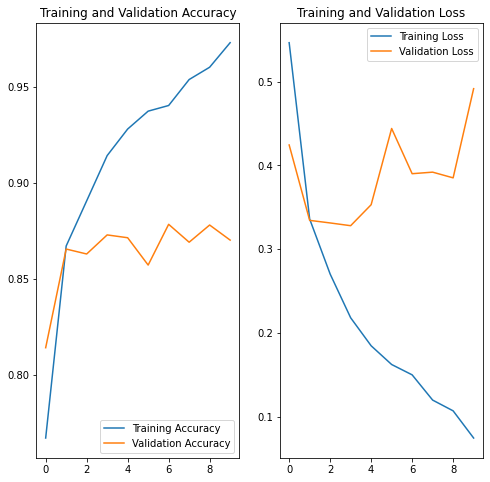

This image most likely belongs to Schematics with a 100.00 percent confidence.
['Schematics', 99.99860525131226]


In [5]:
dataset = generate_dataset()

model = generate_model(dataset)

result = classify_image(model, dataset.class_names, 'chart.png')

print(result)

# Livrable 3 - Captioning

Ce livrable concerne la dernière étape du traitement requis. L’objectif est de créer un réseau de neurones qui génère des légendes pour des photographies, en s’appuyant sur le dataset dataset MS COCO. Le réseau sera composé de deux parties, la partie CNN qui encode les images en un représentation interne, et le partie RNN utilise cette représentation pour prédire l’annotation séquence par séquence. Avant l’entrainement du modèle les images sont prétraitées

Le notebook devra intégrer :
<ul>
    <li>L’architecture schématique complète du réseau utilisé pour le captioning explicitant le type de CNN utilisé pour les prétraitements.</li>
    <li>Un petit descriptif sur le pré-traitements de images et du texte.</li>
    <li>Le code explicitant l’architecture du CNN et du RNN utilisés dans le captioning.</li>
    <li>L’évolution sous forme de courbes des performances du réseau pendant l’entrainement. Affichage de quelques exemples pour les tests.</li>
</ul>

<b>Ce livrable est à fournir pour le 20/01/2021</b>

## Téléchargez et préparez le jeu de données MS-COCO

In [65]:
coco_folder = '/Dataset/3/dataset/coco'

# Download caption annotation files
annotation_folder = coco_folder + '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.') + coco_folder,
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = coco_folder + '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.') + coco_folder,
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

252878848/252872794 [==============================] - 20s 0us/step


### Facultatif: limiter la taille de l'ensemble d'entraînement
Pour accélérer la formation pour ce didacticiel, vous utiliserez un sous-ensemble de 30 000 légendes et leurs images correspondantes pour entraîner notre modèle.

In [70]:
with open(os.path.abspath('.') + coco_folder + '/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

In [77]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)

for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print("Nombre de path d'image enregistrés :", len(train_image_paths))

Nombre de path d'image enregistrés : 6000


In [78]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

On vérifie que l'image correspond bien à l'annotation

<start> Someone riding waves in the water on their surf board <end>


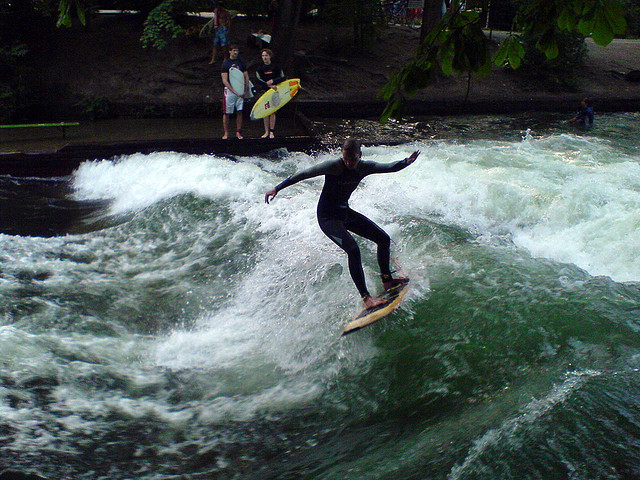

In [85]:
print(train_captions[0])
Image.open(img_name_vector[0])

### Prétraitez les images à l'aide d'InceptionV3

Ensuite, vous utiliserez InceptionV3 pour classer chaque image. Vous extrairez des entités de la dernière couche convolutive.

Tout d'abord, vous allez convertir les images au format attendu d'InceptionV3 en:
<ul>
    <li>Redimensionnement de l'image à 299 px par 299 px</li>
    <li>Prétraitez les images à l'aide de la méthode preprocess_input pour normaliser l'image afin qu'elle contienne des pixels compris entre -1 et 1, ce qui correspond au format des images utilisées pour entraîner InceptionV3.</li>
</ul>

In [87]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialisez InceptionV3 et chargez les poids Imagenet pré-entraînés

Création d'un modèle tf.keras où la couche de sortie est la dernière couche convolutionnelle de l'architecture *InceptionV3*. La forme de la sortie de cette couche est 8x8x2048. 

<ul>
    <li>Vous transférez chaque image à travers le réseau et stockez le vecteur résultant dans un dictionnaire (image_name -> feature_vector).</li>
    <li>Une fois que toutes les images sont passées sur le réseau, vous sélectionnez le dictionnaire et l'enregistrez sur le disque.</li>
</ul>

In [88]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)